# 패키지

In [1]:
import os                           # 운영체제
import tensorflow as tf             # 텐서플로
import tensorflow_addons as tfa     # 텐서플로 에드온
import pandas as pd                 # 판다스
import matplotlib.pyplot as plt     # 그래프 도구
import MSRL                         # Musical Symbol Recognition Library

c:\Users\chorokmoo_win\.conda\envs\new\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# GPU 설정

In [2]:
# 사용 가능한 모든 GPU 리스트
gpus = tf.config.list_physical_devices('GPU')

# 사용할 프로세서 선택 : GPU
if gpus:
    try: tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: print(e)

# 학습 준비

In [3]:
# 데이터셋
msDataset = MSRL.datasets.MusicalSymbolDataset()

# 모델
msModel = MSRL.models.MusicalSymbolModel()

# 모델 주소
model_dir_1 = os.path.join('.', 'models', 'msrm_1.h5')
model_dir_2 = os.path.join('.', 'models', 'msrm_2.h5')
model_dir_3 = os.path.join('.', 'models', 'msrm_3.h5')

# 모델 콜백 함수
cb_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(model_dir_1, save_best_only=True)
cb_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(model_dir_2, save_best_only=True)
cb_checkpoint_3 = tf.keras.callbacks.ModelCheckpoint(model_dir_3, save_best_only=True)
cb_early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# 모델 1

In [4]:
# 데이터셋 준비
ds_1_train, ds_1_validation = msDataset.ds_1()

-- TFDS label shape ------------------
ds 0  : (22617, 133)

-- TFDS label class count ------------------
ds 0  : [1175, 1193, 1224, 1228, 1224, 1074, 537, 524, 544, 553, 1059, 1092, 1124, 1060, 1, 1, 1, 1, 1, 1, 1, 1, 1, 738, 745, 722, 748, 744, 746, 720, 750, 737, 702, 725, 724, 774, 750, 725, 722, 765, 719, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 23, 1, 1, 11, 11, 11, 1655, 1612, 1622, 1585, 1619, 1582, 1641, 1589, 1516, 1622, 1639, 1626, 1587, 1607, 981, 1054, 1054, 987, 1047, 1035, 1036, 986, 1080, 1070, 1120, 1067, 1084, 1088, 1109, 5, 5, 5, 5, 1, 1, 1, 5, 5, 1968, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 47, 2017, 2036, 2073, 2055, 2058, 2117, 2082, 1978, 2025, 2022, 2050, 34, 23, 1, 1]

-- MODEL input node ------------------
[[22617, None, None, 1]]

-- MODEL output node ------------------
[[133]]


In [ ]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_dir_1): model_1 = tf.keras.models.load_model(model_dir_1)   # 모델 불러오기
    else                          : model_1 = msModel.model_1()                         # 모델 생성

    # 모델 학습 설정
    #model_1.compile()

    # 모델 훈련 및 저장
    #history_1 = model_1.fit(
    #    ds_1_train, 
    #    epochs=20, 
    #    initial_epoch=0, 
    #    validation_data=ds_1_validation, 
    #    callbacks=[cb_checkpoint_1, cb_early_stop]
    #)

# 모델 2

In [4]:
# 데이터셋 준비
ds_2_train, ds_2_validation = msDataset.ds_2()

-- TFDS label shape ------------------
ds 0  : (22617, 12)

-- TFDS label class count ------------------
ds 0  : [22502, 6044, 7567, 13256, 8180, 7618, 2011, 9, 14, 58, 15, 2]

-- MODEL input node ------------------
[[22617, None, None, 1]]

-- MODEL output node ------------------
[[12]]


In [5]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_dir_2): model_2 = tf.keras.models.load_model(model_dir_2)   # 모델 불러오기
    else:                           model_2 = msModel.model_2_CRNN()                         # 모델 생성

    # 모델 컴파일 설정
    model_2.compile(
        optimizer='adam',
        loss=MSRL.losses.WeightedBinaryCrossentropy([22502, 6044, 7567, 13256, 8180, 7618, 2011, 9, 14, 58, 15, 2]),
        metrics=[
            MSRL.metrics.Accuracy(),                                # 정확도
            MSRL.metrics.MeanAccuracy(num_classes=12),              # 평균 정확도
            tf.keras.metrics.Precision(),                           # 정밀도
            tf.keras.metrics.Recall(),                              # 재현율
            tfa.metrics.F1Score(num_classes=12, average='macro')    # f1-점수
        ]
    )

    # 모델 훈련
    history_2 = model_2.fit(
        ds_2_train,
        epochs=10,
        initial_epoch=0,
        validation_data=ds_2_validation,
        callbacks=[cb_checkpoint_2, cb_early_stop]
    )

Epoch 1/10
697/697 [==============================] - 240s 271ms/step - loss: 10.6313 - Accuracy: 0.1242 - MeanAccuracy: 0.8608 - precision: 0.7983 - recall: 0.5865 - f1_score: 0.0831 - val_loss: 9.8453 - val_Accuracy: 0.1437 - val_MeanAccuracy: 0.8797 - val_precision: 0.8441 - val_recall: 0.6172 - val_f1_score: 0.0831
Epoch 2/10
697/697 [==============================] - 178s 256ms/step - loss: 8.0494 - Accuracy: 0.2416 - MeanAccuracy: 0.8987 - precision: 0.8462 - recall: 0.7225 - f1_score: 0.0835 - val_loss: 8.7244 - val_Accuracy: 0.2375 - val_MeanAccuracy: 0.8943 - val_precision: 0.8043 - val_recall: 0.7568 - val_f1_score: 0.0829
Epoch 3/10
697/697 [==============================] - 175s 251ms/step - loss: 7.4636 - Accuracy: 0.2933 - MeanAccuracy: 0.9104 - precision: 0.8778 - recall: 0.7419 - f1_score: 0.0857 - val_loss: 6.1327 - val_Accuracy: 0.2844 - val_MeanAccuracy: 0.9214 - val_precision: 0.8679 - val_recall: 0.7948 - val_f1_score: 0.0833
Epoch 4/10
697/697 [===================

In [ ]:
with tf.device('/device:GPU:0'):
    # 모델 훈련
    history_2 = model_2.fit(
        ds_2_train,
        epochs=30,
        initial_epoch=10,
        validation_data=ds_2_validation,
        callbacks=[cb_checkpoint_2, cb_early_stop]
    )

# 모델 3

In [8]:
# 데이터셋 준비
ds_3_train, ds_3_validation = msDataset.ds_3()

-- TFDS label shape ------------------
ds 0  : (22617, 12)
ds 1  : (22617, 11)
ds 2  : (22617, 14)
ds 3  : (22617, 5)
ds 4  : (22617, 9)
ds 5  : (22617, 18)
ds 6  : (22617, 8)
ds 7  : (22617, 7)
ds 8  : (22617, 12)
ds 9  : (22617, 9)
ds 10 : (22617, 14)
ds 11 : (22617, 6)
ds 12 : (22617, 15)
ds 13 : (22617, 2)

-- TFDS label class count ------------------
ds 0  : [22502, 6044, 7567, 13256, 8180, 7618, 2011, 9, 14, 58, 15, 2]
ds 1  : [2017, 2036, 2073, 2055, 2058, 2117, 2082, 1978, 2025, 2022, 2050]
ds 2  : [1655, 1612, 1622, 1585, 1619, 1582, 1641, 1589, 1516, 1622, 1639, 1626, 1587, 1607]
ds 3  : [1175, 1193, 1224, 1228, 1224]
ds 4  : [1074, 537, 524, 544, 553, 1059, 1092, 1124, 1060]
ds 5  : [738, 745, 722, 748, 744, 746, 720, 750, 737, 702, 725, 724, 774, 750, 725, 722, 765, 719]
ds 6  : [981, 1054, 1054, 987, 1047, 1035, 1036, 986]
ds 7  : [1080, 1070, 1120, 1067, 1084, 1088, 1109]
ds 8  : [5, 5, 5, 5, 1, 1, 1, 5, 5, 1968, 5, 5]
ds 9  : [1, 1, 1, 1, 1, 1, 1, 1, 1]
ds 10 : [1, 1, 1,

In [8]:
# 그래프 초기화
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    # 모델 존재 확인
    if os.path.exists(model_dir_3): model_3 = tf.keras.models.load_model(model_dir_3)   # 모델 불러오기
    else                          : model_3 = msModel.model_3()                         # 모델 생성

    # 모델 학습 설정
    #model_3.compile()

    # 모델 훈련 및 저장
    #history_3 = model_3.fit(
    #    ds_3_train, 
    #    epochs=20, 
    #    initial_epoch=0, 
    #    validation_data=ds_3_validation, 
    #    callbacks=[cb_checkpoint_3, cb_early_stop]
    #)

Epoch 1/10
697/697 [==============================] - 169s 177ms/step - loss: 0.4941 - all_loss: 0.0237 - pitch_loss: 0.1660 - note_loss: 0.0711 - accidental_loss: 0.0536 - articulation_loss: 0.0334 - dynamic_loss: 0.0326 - octave_loss: 0.0453 - ornament_loss: 0.0482 - repetition_loss: 1.7628e-04 - clef_loss: 1.1788e-04 - key_loss: 9.8481e-05 - measure_loss: 0.0193 - rest_loss: 1.2383e-04 - time_loss: 3.9371e-04 - all_accuracy: 3.5879e-04 - pitch_accuracy: 0.0893 - note_accuracy: 0.0783 - accidental_accuracy: 0.7804 - articulation_accuracy: 0.7085 - dynamic_accuracy: 0.4432 - octave_accuracy: 0.6722 - ornament_accuracy: 0.7067 - repetition_accuracy: 0.9056 - clef_accuracy: 0.9983 - key_accuracy: 0.9922 - measure_accuracy: 0.9956 - rest_accuracy: 0.9936 - time_accuracy: 0.9985 - val_loss: 0.4814 - val_all_loss: 0.0231 - val_pitch_loss: 0.1634 - val_note_loss: 0.0710 - val_accidental_loss: 0.0506 - val_articulation_loss: 0.0351 - val_dynamic_loss: 0.0319 - val_octave_loss: 0.0406 - val_o

# 학습 결과

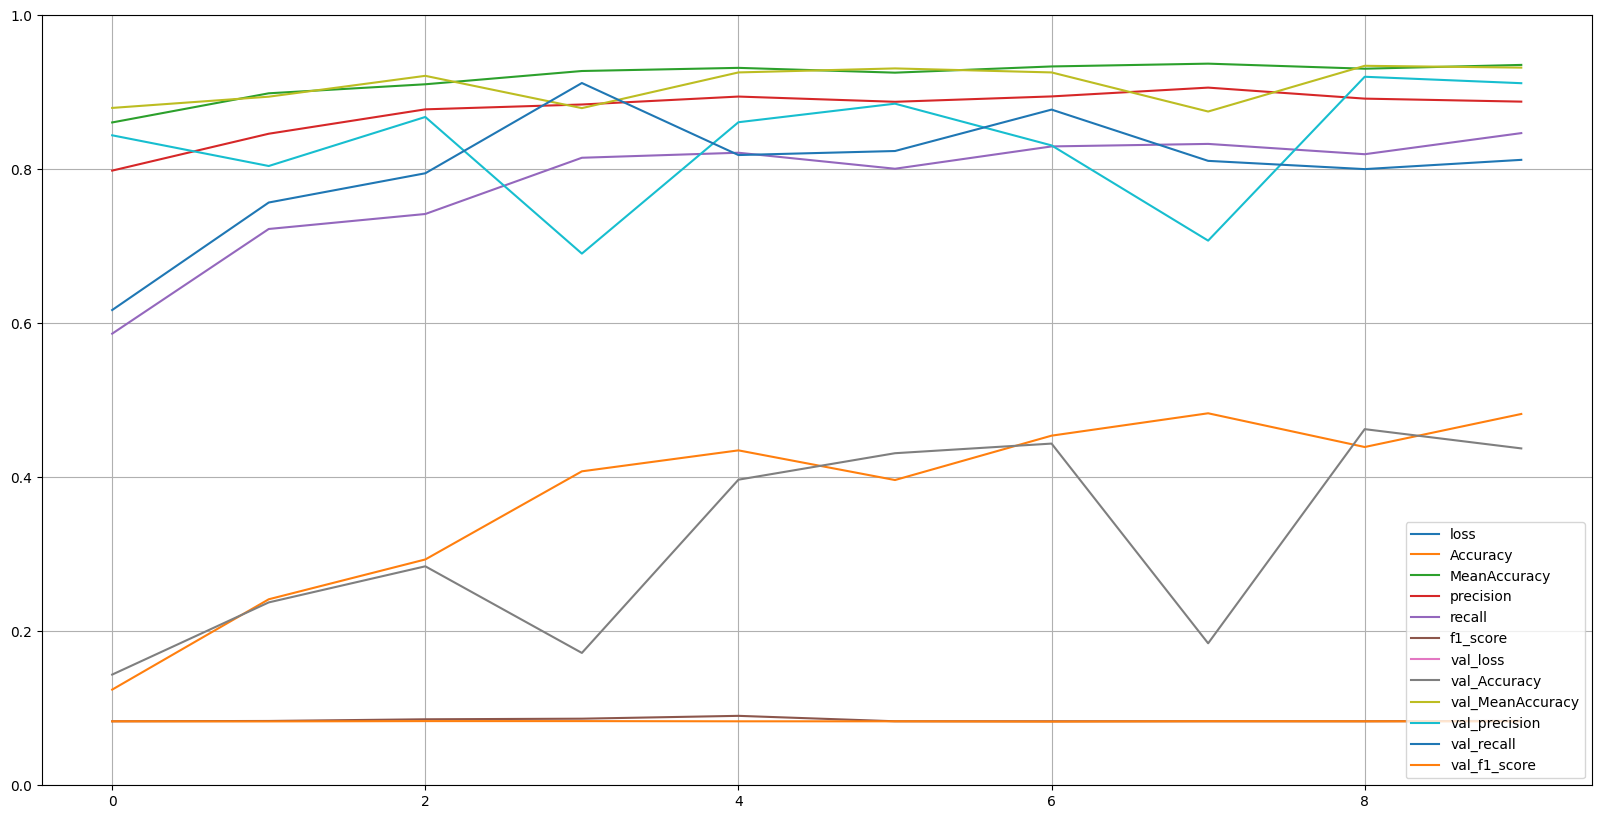

In [6]:
# model_2 훈련 결과 그리기
pd.DataFrame(history_2.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()